In [1]:
# Running on GPU?

import setGPU

setGPU: Setting GPU to: 0


# Autoencoders for Data Certification

In [1]:
# Imports...

import getpass
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os

In [2]:
# Get permission to access EOS (Insert your NICE password)

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

## Load data, and labels

In [4]:
import json
import numpy as np
import pandas as pd

In [5]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [6]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "./JetHT.json"
model_directory = "./"
model_name_pre = "model_pre"
model_name_post = "model_post"
model_name_subs = "model_subs"

In [7]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [8]:
# Load good and bad jets

def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [9]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2807, 2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

In [10]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [11]:
print("Number of anomalies: ", len(data[data["label"] == 1]))
print("Number of inliers: ", len(data[data["label"] == 0]))

Number of anomalies:  2377
Number of inliers:  161307


## Preprocess the data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

In [13]:
# Choose your scaler

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()

In [14]:
# Split the data

# This will work in scikit v19
# X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 0:2806],
#                                                     data["label"],
#                                                     train_size=0.8,
#                                                     test_size=0.2,
#                                                     shuffle=False)

# This will work in scikit older than v19

split = round(0.8*len(data))

def lumi_class(x):
    bins = 0.05
    return int(x / bins)

def lumi_weight(x):
    return weights[x]

data["sample_class"] = data["inst_lumi"].apply(lumi_class)
classes = data[data.label == 0][:split]["sample_class"].values
weights = compute_class_weight("balanced", np.unique(classes), classes)
data["sample_weight"] = data["sample_class"].apply(lumi_weight)

train = data.iloc[:split]
X_train = train.iloc[:, 0:2806]
y_train = train["label"]
X_sample_weights = train[y_train == 0]["sample_weight"]
X_train = X_train[y_train == 0]

test = data.iloc[split:]
X_test = test.iloc[:, 0:2806]
y_test = test["label"]
l_test = test["inst_lumi"]

print("Number of inliers in test set: %s" % sum((y_test == 0).values))
print("Number of anomalies in the test set: %s" % sum((y_test == 1).values))

Number of inliers in test set: 32078
Number of anomalies in the test set: 659


0.3409999907016754
0.0010000000474974513


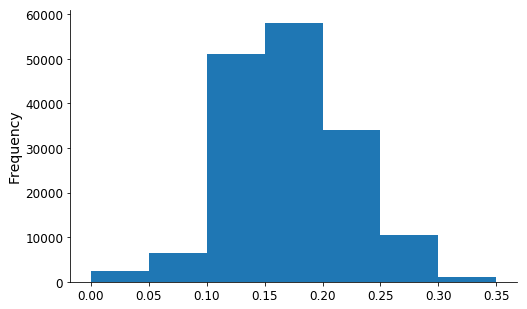

In [15]:
print(max(data["inst_lumi"]))
print(min(data["inst_lumi"]))
data["inst_lumi"].plot.hist(bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]);

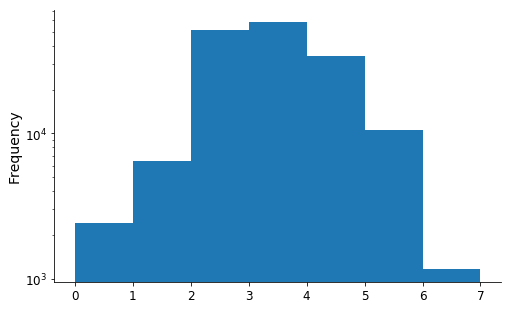

In [16]:
data["sample_class"].plot.hist(bins=[0,1,2,3,4,5,6,7], logy=True);

[  12.36398829    3.38399318    0.4219401     0.3870942     0.73233301
    3.32150467  271.11180124]


<Container object of 7 artists>

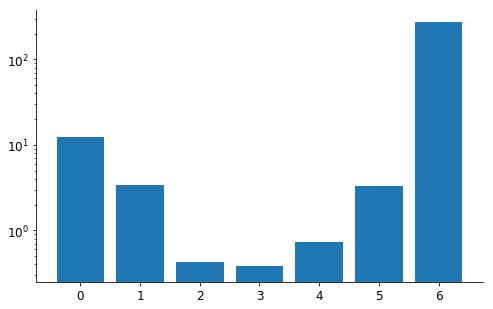

In [17]:
print(weights)
plt.bar(range(7), weights, log=True)

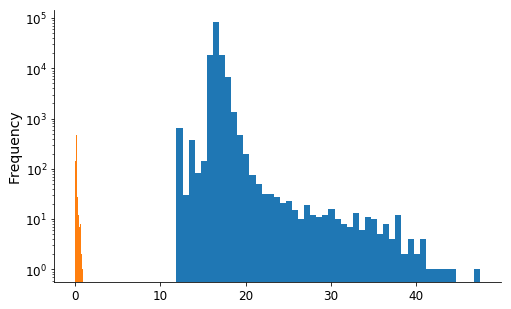

In [18]:
# Normalize the data

scaler.fit(X_train.values)

# Before
X_train[0].plot.hist(bins=50, logy=True);

X_train.iloc[:, 0:2806] = scaler.transform(X_train.values)
X_test.iloc[:, 0:2806] = scaler.transform(X_test.values)

# After
X_train[0].plot.hist(bins=50, logy=True);

# Training the autoencoder

In [19]:
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model, load_model

Using TensorFlow backend.


In [20]:
X_train = X_train.values
X_test = X_test.values

input_dim = X_train.shape[1]

In [22]:
# Define the model

input_layer = Input(shape=(input_dim, ))
x = Dense(150, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer)
x = PReLU()(x)
x = Dense(100, kernel_regularizer=keras.regularizers.l1(10e-5))(x)
x = PReLU()(x)
x = Dense(50, kernel_regularizer=keras.regularizers.l1(10e-5))(x)
x = PReLU()(x)
x = Dense(100, kernel_regularizer=keras.regularizers.l1(10e-5))(x)
x = PReLU()(x)
x = Dense(150, kernel_regularizer=keras.regularizers.l1(10e-5))(x)
x = PReLU()(x)
decoder = Dense(input_dim, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(10e-5))(x)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               421050    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 150)               150       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 100)               100       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 50)                50        
__________

In [23]:
early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=keras.optimizers.Adam(),
                    loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name_pre)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

history = autoencoder.fit(X_train,
                          X_train,
                          epochs=8192,
                          batch_size=1024,
                          shuffle=True,
                          validation_split=0.25,
                          verbose=2,
                          callbacks=[early_stopper, checkpoint_callback]).history

Train on 96921 samples, validate on 32308 samples
Epoch 1/8192
34s - loss: 0.6523 - val_loss: 0.1816
Epoch 2/8192
21s - loss: 0.1297 - val_loss: 0.1071
Epoch 3/8192
20s - loss: 0.1007 - val_loss: 0.0969
Epoch 4/8192
19s - loss: 0.0914 - val_loss: 0.0883
Epoch 5/8192
20s - loss: 0.0833 - val_loss: 0.0809
Epoch 6/8192
20s - loss: 0.0762 - val_loss: 0.0742
Epoch 7/8192
22s - loss: 0.0699 - val_loss: 0.0684
Epoch 8/8192
21s - loss: 0.0644 - val_loss: 0.0634
Epoch 9/8192
20s - loss: 0.0596 - val_loss: 0.0589
Epoch 10/8192
20s - loss: 0.0553 - val_loss: 0.0549
Epoch 11/8192
19s - loss: 0.0515 - val_loss: 0.0515
Epoch 12/8192
22s - loss: 0.0482 - val_loss: 0.0484
Epoch 13/8192
21s - loss: 0.0453 - val_loss: 0.0457
Epoch 14/8192
21s - loss: 0.0427 - val_loss: 0.0432
Epoch 15/8192
21s - loss: 0.0404 - val_loss: 0.0411
Epoch 16/8192
21s - loss: 0.0384 - val_loss: 0.0392
Epoch 17/8192
21s - loss: 0.0365 - val_loss: 0.0375
Epoch 18/8192
22s - loss: 0.0349 - val_loss: 0.0361
Epoch 19/8192
23s - los

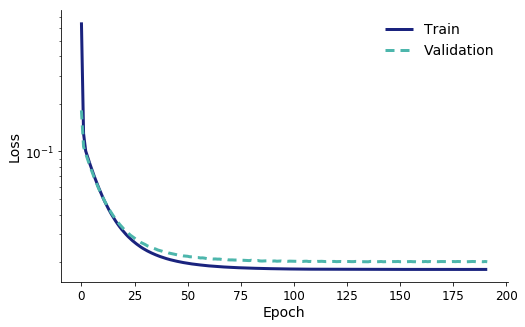

In [24]:
def plot_loss(data):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

plot_loss(history)

In [21]:
# Reload saved model

autoencoder = load_model("%s%s.h5" % (model_directory, model_name_pre))

In [22]:
# Run predictions

predictions = autoencoder.predict(X_test)

In [23]:
legend = [{"name": 'pf_jets', "start": 0, "end": 777, "color": color_palette["Indigo"][100]},
          {"name": 'cal_jet_mets', "start": 778, "end": 946, "color": color_palette["Indigo"][300]},
          {"name": 'pho', "start": 947, "end": 1283, "color": color_palette["Indigo"][500]},
          {"name": 'muons', "start": 1284, "end": 1788, "color": color_palette["Indigo"][700]},
          {"name": 'pf_jets2', "start": 1789, "end": 1894, "color": color_palette["Indigo"][900]},
          {"name": 'pf_mets', "start": 1895, "end": 1923, "color": color_palette["Indigo"][200]},
          {"name": 'nvtx', "start": 1924, "end": 1925, "color": color_palette["Indigo"][400]},
          {"name": 'cal_jet_mets2', "start": 1925, "end": 2037, "color": color_palette["Indigo"][600]},
          {"name": 'sc', "start": 2038, "end": 2129, "color": color_palette["Indigo"][800]},
          {"name": 'cc', "start": 2130, "end": 2172, "color": color_palette["Teal"][100]},
          {"name": 'pho2', "start": 2173, "end": 2369, "color": color_palette["Teal"][300]},
          {"name": 'muons2', "start": 2370, "end": 2476, "color": color_palette["Teal"][500]},
          {"name": 'ebs', "start": 2497, "end": 2707, "color": color_palette["Teal"][700]},
          {"name": 'hbhef', "start": 2708, "end": 2771, "color": color_palette["Teal"][900]},
          {"name": 'presh', "start": 2772, "end": 2810, "color": color_palette["Teal"][400]}]

In [24]:
# Get error

def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)

scores = get_error_df(X_test, predictions, mode="topn")

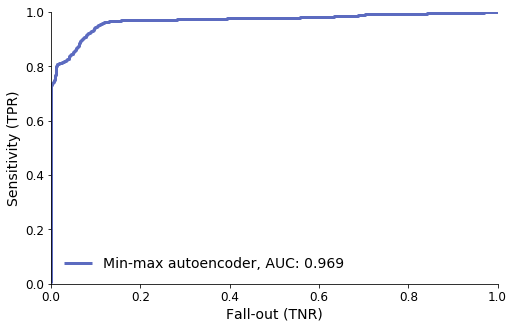

In [25]:
#Make ROC_curve

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

def get_roc_curve(label, score, legend_label):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    fpr, tpr, thresholds = roc_curve(label, score)
    roc_auc = round(auc(fpr, tpr), 3)
    
    plt.plot(fpr,
             tpr,
             linewidth=3,
             color=color_palette["Indigo"][400],
             linestyle=line_styles[0],
             label=("%s, AUC: %s" % (legend_label, roc_auc)))

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show();
    
get_roc_curve(y_test.values, scores, "Min-max autoencoder")

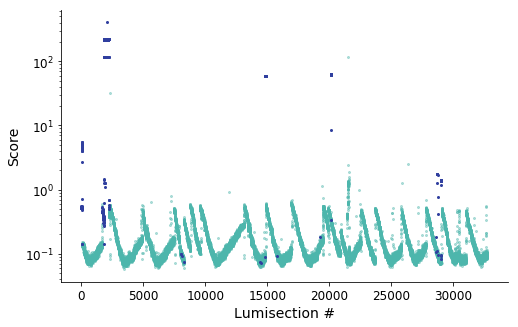

In [26]:
# Plot lumi vs error

fig, ax = plt.subplots()

plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
         scores[y_test == 0],
         color=color_palette["Teal"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
         scores[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("Lumisection #")
plt.show();

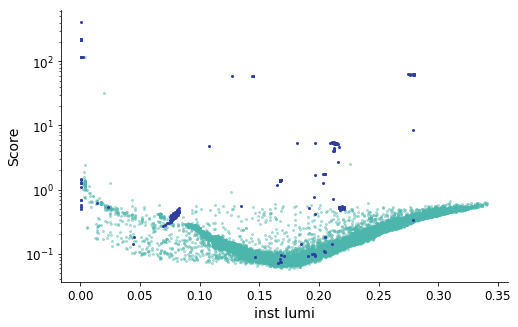

In [28]:
# Plot inst_lumi vs error

fig, ax = plt.subplots()

plt.plot(l_test[y_test == 0],
         scores[y_test == 0],
         color=color_palette["Teal"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(l_test[y_test == 1],
         scores[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("inst lumi")
plt.show();

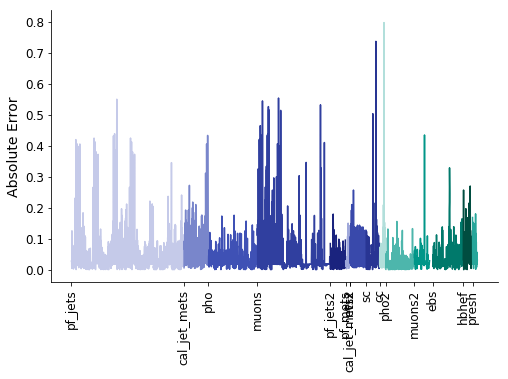

In [35]:
# Choose lumisection
INDEX = 100    

reconstruction = abs(X_test[INDEX] - predictions[INDEX])
features = [i for i in range(reconstruction.shape[0])]

for l in legend:
    plt.plot(features[l["start"]:l["end"]],
             reconstruction[l["start"]:l["end"]],
             color=l["color"])

plt.ylabel("Absolute Error")
plt.xticks([l["start"] for l in legend], [l["name"] for l in legend], rotation='vertical')
plt.show();

In [33]:
# Define the model

input_layer2 = Input(shape=(input_dim, ))
x2 = Dense(150, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer2)
x2 = PReLU()(x2)
x2 = Dense(100, kernel_regularizer=keras.regularizers.l1(10e-5))(x2)
x2 = PReLU()(x2)
x2 = Dense(50, kernel_regularizer=keras.regularizers.l1(10e-5))(x2)
x2 = PReLU()(x2)
x2 = Dense(100, kernel_regularizer=keras.regularizers.l1(10e-5))(x2)
x2 = PReLU()(x2)
x2 = Dense(150, kernel_regularizer=keras.regularizers.l1(10e-5))(x2)
x2 = PReLU()(x2)
decoder2 = Dense(input_dim, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(10e-5))(x2)

autoencoder2 = Model(inputs=input_layer2, outputs=decoder2)
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 150)               421050    
_________________________________________________________________
p_re_lu_11 (PReLU)           (None, 150)               150       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               15100     
_________________________________________________________________
p_re_lu_12 (PReLU)           (None, 100)               100       
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, 50)                50        
__________

In [ ]:
early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder2.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name_post)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

history = autoencoder2.fit(X_train,
                           X_train,
                           epochs=8192,
                           sample_weight=X_sample_weights.values,
                           batch_size=1024,
                           shuffle=True,
                           validation_split=0.25,
                           verbose=2,
                           callbacks=[early_stopper, checkpoint_callback]).history

Train on 96921 samples, validate on 32308 samples
Epoch 1/8192
22s - loss: 0.6270 - val_loss: 0.2612
Epoch 2/8192
20s - loss: 0.1071 - val_loss: 0.1806
Epoch 3/8192
21s - loss: 0.0808 - val_loss: 0.1652
Epoch 4/8192
21s - loss: 0.0740 - val_loss: 0.1521
Epoch 5/8192
20s - loss: 0.0680 - val_loss: 0.1407
Epoch 6/8192
20s - loss: 0.0627 - val_loss: 0.1305
Epoch 7/8192
21s - loss: 0.0581 - val_loss: 0.1216
Epoch 8/8192
20s - loss: 0.0540 - val_loss: 0.1139
Epoch 9/8192
20s - loss: 0.0505 - val_loss: 0.1071
Epoch 10/8192
20s - loss: 0.0473 - val_loss: 0.1010
Epoch 11/8192
21s - loss: 0.0446 - val_loss: 0.0957
Epoch 12/8192
20s - loss: 0.0421 - val_loss: 0.0910
Epoch 13/8192
21s - loss: 0.0400 - val_loss: 0.0869
Epoch 14/8192
21s - loss: 0.0381 - val_loss: 0.0831
Epoch 15/8192
23s - loss: 0.0364 - val_loss: 0.0800
Epoch 16/8192
23s - loss: 0.0349 - val_loss: 0.0771
Epoch 17/8192
23s - loss: 0.0336 - val_loss: 0.0745
Epoch 18/8192
23s - loss: 0.0324 - val_loss: 0.0723
Epoch 19/8192
25s - los

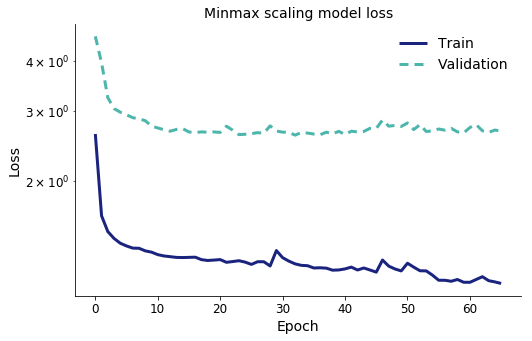

In [95]:
def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

plot_loss(history, "Minmax scaling model loss")

In [29]:
# Reload saved model

autoencoder2 = load_model("%s%s.h5" % (model_directory, model_name_post))

In [30]:
# Run predictions

predictions2 = autoencoder2.predict(X_test)

In [31]:
scores2 = get_error_df(X_test, predictions2, mode="topn")

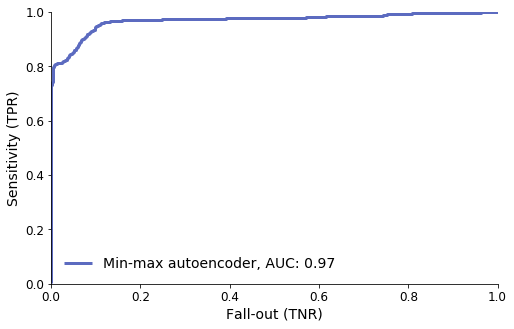

In [32]:
#Make ROC_curve

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

def get_roc_curve(label, score, legend_label):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    fpr, tpr, thresholds = roc_curve(label, score)
    roc_auc = round(auc(fpr, tpr), 3)
    
    plt.plot(fpr,
             tpr,
             linewidth=3,
             color=color_palette["Indigo"][400],
             linestyle=line_styles[0],
             label=("%s, AUC: %s" % (legend_label, roc_auc)))

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show();
    
get_roc_curve(y_test.values, scores2, "Min-max autoencoder")

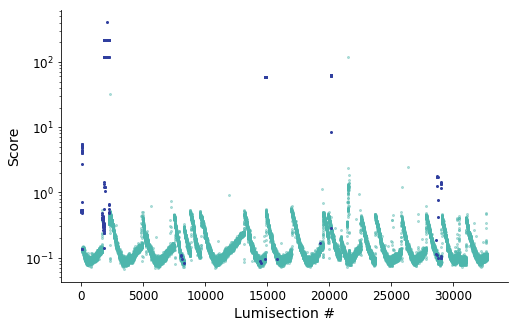

In [33]:
# Plot lumi vs error

fig, ax = plt.subplots()

plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
         scores2[y_test == 0],
         color=color_palette["Teal"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
         scores2[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("Lumisection #")
plt.show();

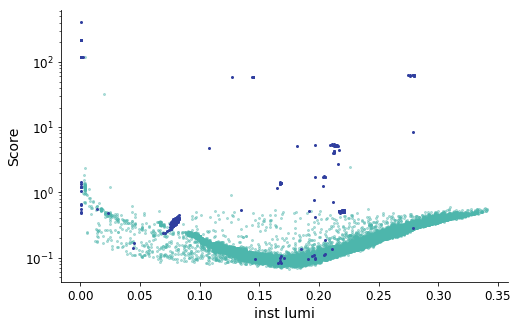

In [34]:
# Plot inst_lumi vs error

fig, ax = plt.subplots()

plt.plot(l_test[y_test == 0],
         scores2[y_test == 0],
         color=color_palette["Teal"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(l_test[y_test == 1],
         scores2[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("inst lumi")
plt.show();

In [57]:
train.sample(n=10000, weights="sample_weight")

,0,1,2,3,4,5,6,7,8,9,...,2803,2804,2805,2806,run,lumi,inst_lumi,label,sample_class,sample_weight
4044,16.497530,40.412708,5.000026,6.512053,8.557202,12.096941,1666.878052,-0.008269,2.730124,-5.074798,...,-1.244521,0.0,1.245103,3.141370,275836,430,0.158,1,3,0.387094
105547,16.252512,38.271591,5.000038,6.756098,9.044626,12.815246,1312.044922,-0.039669,2.726086,-5.063468,...,-1.217456,0.0,1.202129,3.141369,279931,927,0.188,0,3,0.387094
119640,12.215345,16.914555,5.000154,6.764656,9.121961,12.910728,686.815125,-0.033497,2.715600,-5.084784,...,-1.244998,0.0,1.206403,3.141430,281613,604,0.010,0,0,12.363988
124113,17.539051,35.453320,5.000009,7.781200,11.307534,16.503630,1151.624023,-0.004096,2.885568,-5.101958,...,-1.296562,0.0,1.207489,3.141500,281797,154,0.303,0,6,271.111801
95070,16.910372,41.890411,5.000008,6.359434,8.240592,11.591731,1021.397766,-0.033737,2.642581,-5.083655,...,-1.189321,0.0,1.223337,3.141350,279694,1880,0.141,0,2,0.421940
124130,17.618614,36.096596,5.000037,7.734166,11.236567,16.417084,1155.252441,-0.003677,2.880234,-5.096746,...,-1.270573,0.0,1.232884,3.141582,281797,171,0.300,0,6,271.111801
59876,16.856323,36.127224,5.000042,7.380824,10.447745,15.120008,1288.599854,-0.008763,2.886416,-5.095321,...,-1.240093,0.0,1.230796,3.141590,277218,59,0.259,0,5,3.321505
124123,17.563040,35.449314,5.000022,7.755456,11.263635,16.465858,1337.658447,-0.004082,2.880730,-5.098510,...,-1.240093,0.0,1.235761,3.141572,281797,164,0.302,0,6,271.111801
61395,16.912733,34.498848,5.000018,7.526355,10.778351,15.636395,1240.059692,-0.008116,2.903297,-5.096786,...,-1.245494,0.0,1.264694,3.141382,278017,172,0.279,0,5,3.321505
104124,16.926964,42.294327,5.000001,6.381721,8.283312,11.678176,1232.193970,-0.019316,2.648990,-5.075730,...,-1.262869,0.0,1.155274,3.141398,279841,2056,0.141,0,2,0.421940


In [58]:
train = train.sample(n=12000, weights="sample_weight")
X_train = train.iloc[:, 0:2806]
y_train = train["label"]
X_train = X_train[y_train == 0]
X_train.iloc[:, 0:2806] = scaler.transform(X_train.values)
X_train = X_train.values

In [59]:
# Define the model

input_layer3 = Input(shape=(input_dim, ))
x3 = Dense(150, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer3)
x3 = PReLU()(x3)
x3 = Dense(100, kernel_regularizer=keras.regularizers.l1(10e-5))(x3)
x3 = PReLU()(x3)
x3 = Dense(50, kernel_regularizer=keras.regularizers.l1(10e-5))(x3)
x3 = PReLU()(x3)
x3 = Dense(100, kernel_regularizer=keras.regularizers.l1(10e-5))(x3)
x3 = PReLU()(x3)
x3 = Dense(150, kernel_regularizer=keras.regularizers.l1(10e-5))(x3)
x3 = PReLU()(x3)
decoder3 = Dense(input_dim, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(10e-5))(x3)

autoencoder3 = Model(inputs=input_layer3, outputs=decoder3)
autoencoder3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               421050    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 150)               150       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 100)               100       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 50)                50        
__________

In [60]:
early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder3.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name_subs)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

history = autoencoder3.fit(X_train,
                           X_train,
                           epochs=8192,
                           batch_size=1024,
                           shuffle=True,
                           validation_split=0.25,
                           verbose=2,
                           callbacks=[early_stopper, checkpoint_callback]).history

Train on 8736 samples, validate on 2912 samples
Epoch 1/8192
2s - loss: 2.0752 - val_loss: 1.6921
Epoch 2/8192
1s - loss: 1.4473 - val_loss: 1.1370
Epoch 3/8192
1s - loss: 0.9545 - val_loss: 0.7309
Epoch 4/8192
1s - loss: 0.6115 - val_loss: 0.4752
Epoch 5/8192
1s - loss: 0.4197 - val_loss: 0.3715
Epoch 6/8192
1s - loss: 0.3522 - val_loss: 0.3144
Epoch 7/8192
1s - loss: 0.2933 - val_loss: 0.2711
Epoch 8/8192
1s - loss: 0.2566 - val_loss: 0.2379
Epoch 9/8192
1s - loss: 0.2278 - val_loss: 0.2129
Epoch 10/8192
1s - loss: 0.2051 - val_loss: 0.1927
Epoch 11/8192
1s - loss: 0.1860 - val_loss: 0.1753
Epoch 12/8192
1s - loss: 0.1698 - val_loss: 0.1606
Epoch 13/8192
1s - loss: 0.1561 - val_loss: 0.1481
Epoch 14/8192
1s - loss: 0.1443 - val_loss: 0.1377
Epoch 15/8192
1s - loss: 0.1349 - val_loss: 0.1294
Epoch 16/8192
1s - loss: 0.1274 - val_loss: 0.1229
Epoch 17/8192
1s - loss: 0.1217 - val_loss: 0.1183
Epoch 18/8192
1s - loss: 0.1179 - val_loss: 0.1152
Epoch 19/8192
1s - loss: 0.1149 - val_loss:

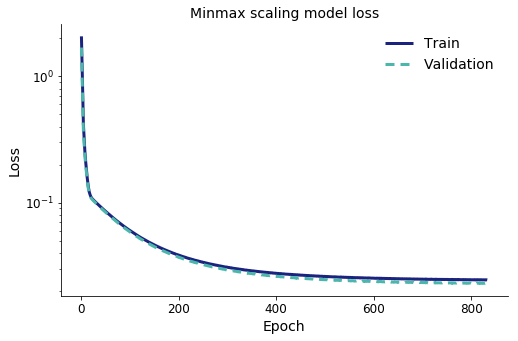

In [61]:
def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

plot_loss(history, "Minmax scaling model loss")

In [35]:
# Reload saved model

autoencoder3 = load_model("%s%s.h5" % (model_directory, model_name_subs))

In [36]:
# Run predictions

predictions3 = autoencoder3.predict(X_test)

In [37]:
scores3 = get_error_df(X_test, predictions2, mode="topn")

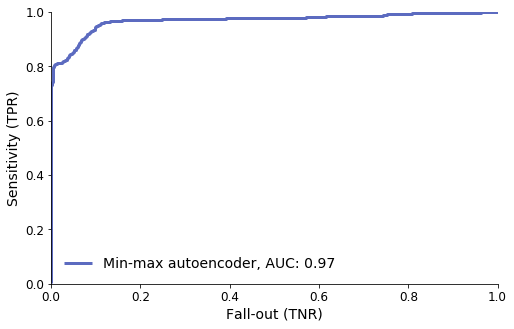

In [38]:
get_roc_curve(y_test.values, scores3, "Min-max autoencoder")

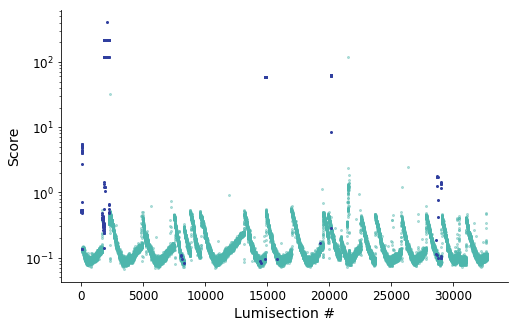

In [39]:
# Plot lumi vs error

fig, ax = plt.subplots()

plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
         scores3[y_test == 0],
         color=color_palette["Teal"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
         scores3[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("Lumisection #")
plt.show();

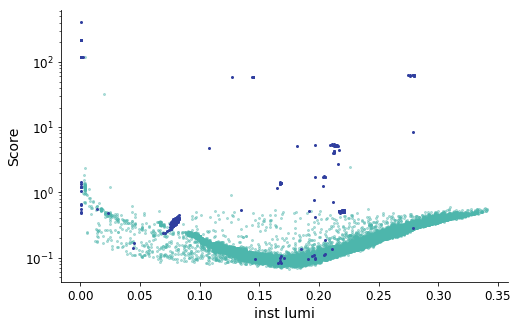

In [40]:
# Plot inst_lumi vs error

fig, ax = plt.subplots()

plt.plot(l_test[y_test == 0],
         scores3[y_test == 0],
         color=color_palette["Teal"][300],
         linestyle='',
         ms=2,
         alpha=0.4,
         marker='o',
         label="Outlier")

plt.plot(l_test[y_test == 1],
         scores3[y_test == 1],
         color=color_palette["Indigo"][700],
         linestyle='',
         ms=2,
         marker='o',
         label="Inlier")

ax.set_yscale("log")
plt.ylabel("Score")
plt.xlabel("inst lumi")
plt.show();